In [1]:
%load_ext autoreload

In [2]:
%autoreload
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl as oc
import dctkit.dec.cochain as C
import dctkit as dt
import pygmsh
import pyvista as pv
from pyvista import themes

[nexus7:81553] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [16]:
dt.config()
#pv.set_jupyter_backend('trame')
pv.global_theme = themes.ParaViewTheme()

In [17]:
lc = 0.2
mesh, _ = util.generate_cube_mesh(lc)
#pv.plot(mesh)
S = util.build_complex_from_mesh(mesh)
num_nodes = S.num_nodes
print("number of nodes = ", num_nodes)
print("number of tets = ", S.S[3].shape[0])
S.get_hodge_star()

number of nodes =  237
number of tets =  741


In [18]:
# boundary conditions
bottom_nodes = np.argwhere(S.node_coords[:,2]<1e-6).flatten()
top_nodes = np.argwhere(abs(S.node_coords[:,2]-1.)<1e-6).flatten()
values = np.zeros(len(bottom_nodes)+len(top_nodes), dtype=dt.float_dtype)
boundary_values = (np.hstack((bottom_nodes,top_nodes)), values)

In [19]:
from functools import partial
from dctkit.physics import poisson as p

def disspot(u, u_prev, deltat):
    u_coch = C.CochainP0(S, u)
    u_prev_coch = C.CochainP0(S, u_prev)
    u_diff = C.sub(u_coch, u_prev_coch)
    return (1/2)*C.inner(u_diff, u_diff)/deltat

energy = partial(p.energy_poisson, S=S)

def obj(u, u_prev, f, k, boundary_values, gamma, deltat):
    en = energy(x=u, f=f, k=k, boundary_values=boundary_values, gamma=gamma)
    return en + disspot(u, u_prev, deltat)

k = 1.
f_vec = np.ones(num_nodes, dtype=dt.float_dtype)
gamma = 1000.
deltat = 0.1

u_0 = np.zeros(num_nodes, dt.float_dtype)
u_prev = u_0

In [20]:
sols = []
prb = oc.OptimizationProblem(dim=num_nodes, state_dim=num_nodes, objfun=obj)
for i in range(10):
    print("t = ", (i+1)*deltat)
    args = {'u_prev': u_prev, 'f': f_vec, 'k': k, 'boundary_values': boundary_values,
        'gamma': gamma, 'deltat': deltat}
    prb.set_obj_args(args)
    u = prb.solve(u_prev, ftol_abs=1e-8, ftol_rel=1e-8)
    u_prev = u.__array__()
    sols.append(u)
prb.last_opt_result

t =  0.1
t =  0.2
t =  0.30000000000000004
t =  0.4
t =  0.5
t =  0.6000000000000001
t =  0.7000000000000001
t =  0.8
t =  0.9
t =  1.0


1

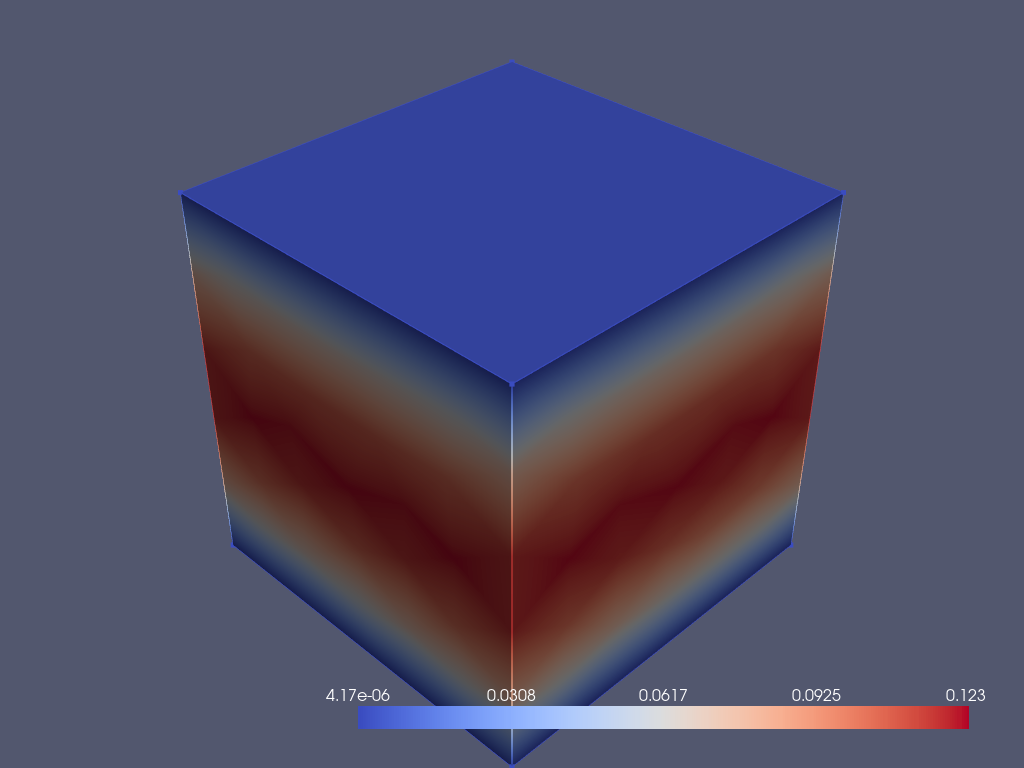

In [21]:
p = pv.Plotter()
p.add_mesh(mesh, scalars=sols[-1])
p.show()

In [30]:
import meshio
filename = "timedata.xdmf"
points = mesh.points
cells = {"tetra": mesh.cells_dict["tetra"]}
with meshio.xdmf.TimeSeriesWriter(filename) as writer:
    writer.write_points_cells(points, cells)
    for i in range(10):
        writer.write_data(i, point_data={"u": sols[i]})